# Credit Risk & Loan Performance: Data Sampling and Exploratory Data Analysis

#### Author: Satveer Kaur
#### Date: 2025-10-19
#### Notebook Purpose:
This notebook focuses on **data sampling and initial exploratory data analysis (EDA)** for the LendingClub Accepted and Rejected Loans datasets.LendingClub Accepted and Rejected Loans datasets. 
The goal is to:
1. Create **representative sample datasets** for faster, efficient exploration while preserving the distribution of key variables.
2. Conduct **initial EDA** to understand data structure, detect potential issues, and uncover early trends in borrower profiles and loan performance.
3. Evaluate **variable distributions, correlations, and data balance** between accepted and rejected loans
4. Prepare the groundwork for deeper **statistical analysis, feature engineering, and visualization** in subsequent notebooks.

#### 1. Load Cleaned Datasets
**Purpose**: Import the **cleaned Accepted and Rejected Loans** CSV files and verify successful loading by checking their shape and basic structure. This ensures both datasets are ready for sampling and further exploratory analysis.

In [1]:
# Importing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split  # for stratified sampling
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
# To see all the columns in the df
pd.set_option('display.max_columns', False)


# Load cleaned datasets
accepted_loans = pd.read_csv("../data/clean_data/accepted_loans_cleaned.csv", low_memory=False)
rejected_loans = pd.read_csv("../data/clean_data/rejected_loans_cleaned.csv")

print(f"Accepted Loans: {accepted_loans.shape}")
print(f"Rejected Loans: {rejected_loans.shape}")

accepted_loans['loan_status'].value_counts(normalize=True)

Accepted Loans: (2260701, 102)
Rejected Loans: (27648741, 7)


loan_status
Fully Paid                                             0.476298
Current                                                0.388521
Charged Off                                            0.118796
Late (31-120 days)                                     0.009496
In Grace Period                                        0.003732
Late (16-30 days)                                      0.001924
Does not meet the credit policy. Status:Fully Paid     0.000879
Does not meet the credit policy. Status:Charged Off    0.000337
Default                                                0.000018
Name: proportion, dtype: float64

#### 2. Create Sample Datasets
**Purpose:**  
The cleaned datasets are large, which can make visualization and analysis slower. To enable efficient exploratory data analysis (EDA), we create **representative samples** that retain the overall data distribution while reducing size.  

This approach allows for faster testing, plotting, and insight generation — especially useful when working on limited local resources.

##### 2.1 Drop Rows with NaN `loan_status` and `state` and change datatype to String
**Purpose:**  
Stratified sampling requires a valid target variable. Rows with missing `loan_status` cannot be assigned to a class and the column is converted to string to ensure proper class handling in the sample.

In [2]:
# Ensure 'loan_status' in accepted loans has no NaNs and is string type
accepted_loans.loc[:,'loan_status'] = accepted_loans.dropna(subset=['loan_status'])
accepted_loans['loan_status'] = accepted_loans['loan_status'].astype(str)
print(f"Accepted Loans: {accepted_loans.shape}, dtype: {accepted_loans['loan_status'].dtype}")

# Ensure 'state' in rejected loans has no NaNs and is string type
rejected_loans.loc[:,'state'] = rejected_loans.dropna(subset=['state'])
rejected_loans['state'] = rejected_loans['state'].astype(str)
print(f"Rejected Loans: {rejected_loans.shape}, dtype: {rejected_loans['state'].dtype}")


Accepted Loans: (2260701, 102), dtype: object
Rejected Loans: (27648741, 7), dtype: object


##### 2.2 Stratified Sampling for Accepted and Rejected Loans
**Purpose:**  
To reduce dataset size while preserving class proportions, we perform stratified sampling on accepted loans (`loan_status`) and rejected loans (`state`).

In [3]:
# Stratified sampling for accepted loans by loan_status
accepted_sample, _ = train_test_split(
    accepted_loans,
    test_size=0.9, # keep 10% for sample 
    stratify=accepted_loans['loan_status'],
    random_state=42
)

# Stratified sampling for rejected loans by state (Since no loan_status column)
rejected_sample, _ = train_test_split(
    rejected_loans,
    test_size=0.9915,
    stratify=rejected_loans['state'],
    random_state=42
)

print(f'Accepted Loans Sample: {accepted_sample.shape}')
print(f'Rejected Loans Sample: {rejected_sample.shape}')

Accepted Loans Sample: (226070, 102)
Rejected Loans Sample: (235014, 7)


##### 2.3 Save Sampled Datasets
**Purpose:**  
To avoid resampling and ensure reproducibility, the stratified samples of accepted and rejected loans as separate CSV files. This allows faster EDA and modeling in later steps.

In [4]:
# Save sampled datasets to CSV
accepted_sample.to_csv('../data/sample_data/accepted_sample.csv', index=False)
rejected_sample.to_csv('../data/sample_data/rejected_sample.csv', index=False)

#### 3. Exploratory Data Analysis (EDA)
**Purpose:**  
Understand the data distributions, identify patterns, spot anomalies, and get insights that will guide feature engineering and modeling.

##### 3.1 Overview of the Data
**Purpose:**  
Get a quick summary of the numeric and categorical features, including counts, distributions, and basic statistics.

In [5]:
# # Set float display format to 2 decimal places for better readability in summary statistics
pd.set_option('display.float_format',lambda x : '%.2f' % x)

# Numeric summary
accepted_sample.describe()

,amount_requested,funded_amount,funded_amount_invested,interest_rate,installment,annual_income,debt_to_income_ratio,delinquencies_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_accounts,public_records,revolving_balance,revolving_utilization,total_accounts,out_prncp,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,...,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,225887.00,226066.00,226067.00,226067.00,226066.00,110207.00,226066.00,226066.00,226067.00,225889.00,226066.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226056.00,226067.00,226066.00,218841.00,218841.00,139411.00,139411.00,139411.00,139411.00,134997.00,139411.00,119257.00,...,218841.00,139411.00,139411.00,139411.00,221009.00,218834.00,218612.00,218499.00,226056.00,226066.00,211964.00,218841.00,218841.00,218841.00,221009.00,218738.00,196309.00,73846.00,218841.00,218841.00,218841.00,220108.00,218841.00,218841.00,218841.00,218841.00,218841.00,220108.00,210443.00,218841.00,218841.00,218841.00,218829.00,218566.00,225936.00,226059.00,218841.00,221009.00,221009.00,218841.00
mean,15070.38,15065.51,15047.40,13.09,446.55,77962.65,18.84,0.31,698.58,702.58,0.58,34.57,11.61,0.20,16593.83,50.38,24.17,4208.24,12110.47,12092.99,9529.48,2436.11,1.56,143.32,23.89,3440.47,687.53,675.44,0.02,1.00,0.00,224.33,142517.08,0.93,2.79,0.68,1.56,21.14,35581.65,69.18,...,34514.87,1.01,1.47,2.05,4.52,13545.68,11374.55,57.91,0.01,12.43,126.00,181.63,14.01,8.28,1.56,24.78,6.99,35.82,0.50,3.68,5.63,4.78,7.73,8.43,8.24,14.00,5.57,11.63,0.00,0.00,0.08,2.08,94.10,42.46,0.13,0.05,178261.58,51078.97,23175.26,43865.30
std,9216.52,9215.14,9219.25,4.83,268.00,72516.15,15.01,0.88,33.05,33.05,0.89,21.94,5.64,0.60,22783.18,24.73,11.99,7357.38,9942.52,9938.24,8351.54,2691.52,12.38,742.99,130.68,6049.00,73.03,111.02,0.15,0.00,0.07,1805.69,159859.47,1.14,3.00,0.92,1.57,25.77,44099.20,23.82,...,40402.50,1.48,2.65,2.39,3.16,16384.85,16597.94,28.61,0.10,838.59,53.30,96.90,17.54,9.19,1.91,32.36,5.95,22.36,1.36,2.33,3.38,3.05,4.71,7.34,4.69,8.05,3.29,5.64,0.03,0.06,0.51,1.83,9.06,36.23,0.37,0.41,181342.31,49872.97,22877.56,45177.30
min,500.00,500.00,0.00,5.31,14.77,0.00,0.00,0.00,615.00,619.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,8000.00,8000.00,8000.00,9.49,252.14,46000.00,11.90,0.00,675.00,679.00,0.00,16.00,8.00,0.00,5960.00,31.60,15.00,0.00,4542.04,4528.03,3000.00,728.72,0.00,0.00,0.00,310.38,654.00,650.00,0.00,1.00,0.00,0.00,29198.00,0.00,1.00,0.00,0.00,7.00,8769.00,55.00,...,14600.00,0.00,0.00,0.00,2.00,3097.00,1719.00,35.40,0.00,0.00,96.00,117.00,4.00,3.00,0.00,6.00,2.00,17.00,0.00,2.00,3.00,3.00,4.00,3.00,5.00,8.00,3.00,8.00,0.00,0.00,0.00,1.00,91.30,0.00,0.00,0

In [ ]:
#Categorical summary of loan_status
accepted_sample['loan_status'].value_counts()

loan_status
Fully Paid                                             107675
Current                                                 87832
Charged Off                                             26856
Late (31-120 days)                                       2147
In Grace Period                                           843
Late (16-30 days)                                         435
Does not meet the credit policy. Status:Fully Paid        199
Does not meet the credit policy. Status:Charged Off        76
Default                                                     4
nan                                                         3
Name: count, dtype: int64

In [7]:
# Categorical summary of state
rejected_sample['state'].value_counts()

state
CA    27558
TX    21212
FL    18424
NY    16925
GA     9211
PA     8905
OH     8596
IL     8509
NC     7343
NJ     7253
MI     6423
VA     6280
MD     5055
AZ     5006
TN     4896
MA     4648
IN     4397
WA     4232
MO     4217
AL     4192
CO     3995
SC     3981
LA     3584
WI     3074
MN     3054
KY     2976
CT     2886
NV     2835
OK     2602
AR     2476
OR     2410
MS     2357
KS     1960
UT     1525
NM     1406
HI     1323
NH     1000
NE      959
RI      953
WV      903
DE      800
ID      682
ME      670
MT      605
AK      514
SD      484
DC      449
VT      438
WY      422
ND      405
IA        4
Name: count, dtype: int64

##### 3.2 Categorical Univariate Analysis 

##### 3.2.1 Loan Status Distribution
**Purpose:**  
To understand the distribution of loan outcomes, including the majority and minority categories. Small categories are grouped into `Other` for clarity.

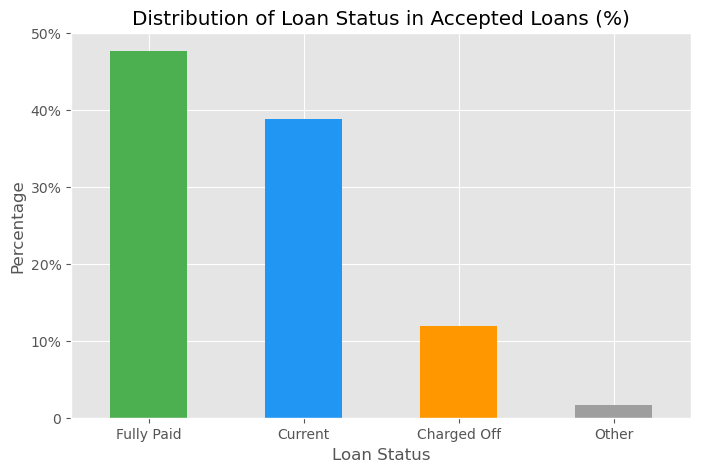

In [8]:
# Combine small categories
top_loan_status = ['Fully Paid', 'Current','Charged Off']
accepted_sample['loan_status_grouped'] = accepted_sample['loan_status'].apply(
    lambda x: x if x in top_loan_status else 'Other'
)

#calculate percentage
loan_status_pct = accepted_sample['loan_status_grouped'].value_counts(normalize=True) * 100

#plot 
plt.figure(figsize=(8,5))
loan_status_pct.plot(kind='bar', color=['#4CAF50', '#2196F3', '#FF9800', '#9E9E9E'])
ax = plt.gca()
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,pos: f'{int(y)}%' if y!=0 else '0'))
plt.xlabel('Loan Status')
plt.ylabel('Percentage')
plt.title('Distribution of Loan Status in Accepted Loans (%)')
plt.xticks(rotation=0) 
plt.show()

##### 3.2.2 Loan Grades, Term, and Home Ownership
**Purpose:**  
To understand the distribution of key categorical features affecting credit risk and repayment patterns.

In [9]:
# Combine small categories of home_ownership
top_home_ownership = ['MORTGAGE', 'RENT','OWN']
accepted_sample['home_ownership_grouped'] = accepted_sample['home_ownership'].apply(
    lambda x: x if x in top_home_ownership else 'Other'
)

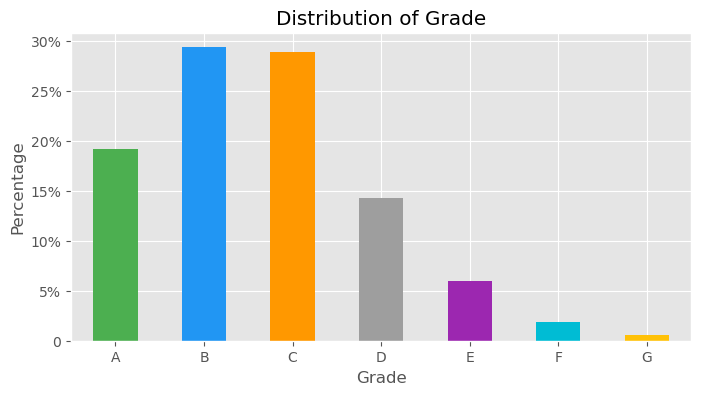

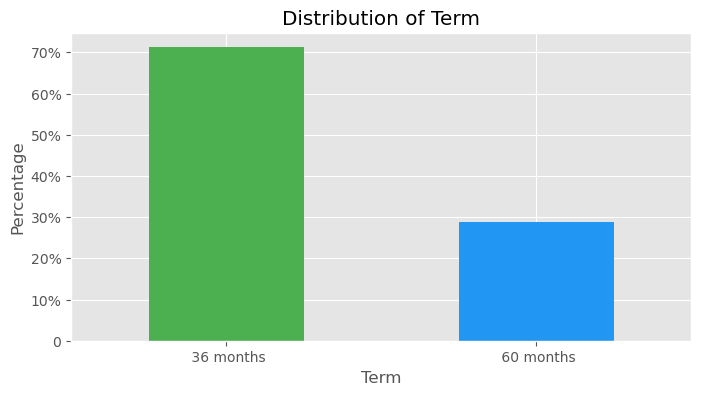

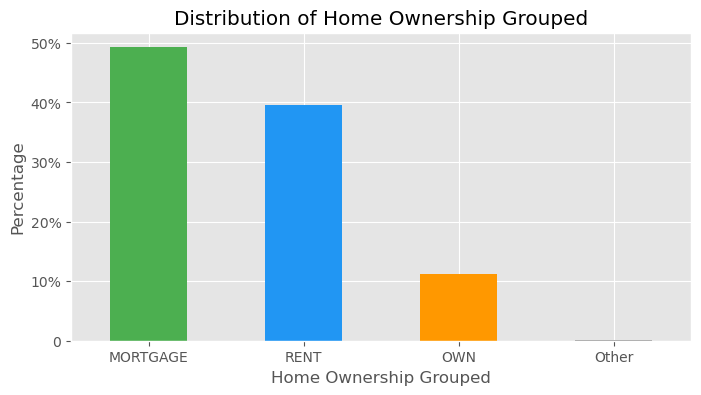

In [10]:
categorical_cols = ['grade', 'term', 'home_ownership_grouped']
colors = ['#4CAF50', '#2196F3', '#FF9800', '#9E9E9E', '#9C27B0', '#00BCD4', '#FFC107']

for col in categorical_cols:
    plt.figure(figsize=(8,4))
    if col == 'home_ownership_grouped':
        counts = (accepted_sample[col].value_counts(normalize=True) * 100)
    else:
        counts = (accepted_sample[col].value_counts(normalize=True) * 100).sort_index()
    counts.plot(kind='bar', color=colors[:len(counts)])
    ax = plt.gca()
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,pos: f'{int(y)}%' if y!=0 else '0'))
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylabel('Percentage')
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xticks(rotation=0)
    plt.show()


##### 5.3 Summary and Next Steps
##### Summary

- Successfully created stratified and random samples of both accepted and rejected loan datasets.
- Verified representativeness of samples through distribution and proportion checks.
- Performed initial univariate and bivariate EDA to explore key numerical and categorical features.
- Identified early data patterns relevant to loan approval trends and credit risk characteristics.

##### Next Steps

Moving forward, the next phase will involve:
- Conducting in-depth statistical EDA to explore relationships between features and loan outcomes.
- Handling missing values and outliers more contextually based on analytical needs.
- Creating derived and engineered variables to support predictive modeling.
- Developing visual dashboards and feature-level insights for stakeholder presentation.

The next phase will be documented in [`3_numerical_and_bivariate_EDA.ipynb`](3_numerical_and_bivariate_EDA.IPYNB)